# Import library

packages allowed for use during inference

In [144]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms


import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

packages during training

In [145]:
from thop import profile
from torchsummary import summary
from byol_pytorch import BYOL

# Hyperparameters


In [146]:
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Custom Dataset


先計算此training dataset的mean & std (直接用imagenet的)

In [147]:
train_mean = [0.485, 0.456, 0.406]
train_std = [0.229, 0.224, 0.225]

Custom dataset

In [148]:
# Custom dataset class for unlabeled images
class UnlabeledDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = [image for image in os.listdir(data_dir) if image.endswith('jpg')]

        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.data_dir, img_name) #complete the list of filename
        # convert to a PIL rgb image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image #no label


建train transform(SSL只有unlabeled training set)

In [149]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

#transform_val = transforms.Compose([
#    transforms.Resize(128),
#    transforms.CenterCrop(128),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=train_mean, std=train_std),
#])


用P1_train_val_CustomDataset產生custom train & val dataset，再產生trainloader & valloader

In [150]:
train_dataset = UnlabeledDataset(data_dir='../hw1_data/p1_data/mini/train', transform=transform_train)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [151]:
# print shape
image_first_batch = next(iter(trainloader))  #get first batch's image & mask
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print(image_first_batch[2][0][50][60])

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([32, 3, 128, 128])
tensor(0.3138)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


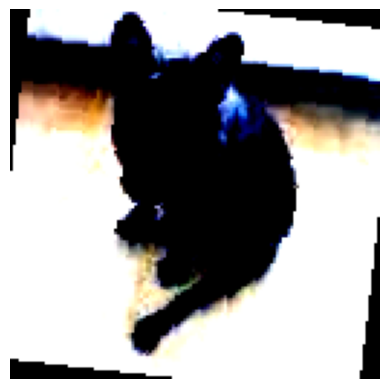

In [152]:
# visualize wo normalization
idx = 6
first_image = image_first_batch[idx]

# Convert the tensor to numpy array
image_np = first_image.numpy()

# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Build Model

instance model

並放到device上(gpu?)


In [153]:
net = models.resnet50(weights=None)  # No pretrained weights
net.fc = torch.nn.Identity()  # Remove the final classification layer
net = net.to(device)
# FC layer(classifier) is not used in SSL pretrain phase, only train backbone. 
# So it doesnt matter resnet50 has 1000 output logits in pretrain phase.

'''
# Number of input features to the original FC layer
num_features = net.fc.in_features  # Typically 2048 for ResNet50

# Create a new Classifier
class Classifier(nn.Module):
    def __init__(self, num_features, hidden1=1024, hidden2=512, num_classes=65, dropout_prob=0.5):
        super(Classifier, self).__init__()
        # First layer
        self.fc1 = nn.Linear(num_features, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch Normalization for first hidden layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout after first hidden layer

        # Second layer
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch Normalization for second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout after second hidden layer

        # Final layer (output)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        # Forward through the first layer
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.dropout1(x)  # Dropout
        
        # Forward through the second layer
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.dropout2(x)  # Dropout

        # Output layer (no activation, used for logits)
        x = self.fc3(x)
        return x

# Replace the final fully connected layer in ResNet50 with the new MLP head
net.fc = Classifier(num_features)
'''


'\n# Number of input features to the original FC layer\nnum_features = net.fc.in_features  # Typically 2048 for ResNet50\n\n# Create a new Classifier\nclass Classifier(nn.Module):\n    def __init__(self, num_features, hidden1=1024, hidden2=512, num_classes=65, dropout_prob=0.5):\n        super(Classifier, self).__init__()\n        # First layer\n        self.fc1 = nn.Linear(num_features, hidden1)\n        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch Normalization for first hidden layer\n        self.relu1 = nn.ReLU()\n        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout after first hidden layer\n\n        # Second layer\n        self.fc2 = nn.Linear(hidden1, hidden2)\n        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch Normalization for second hidden layer\n        self.relu2 = nn.ReLU()\n        self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout after second hidden layer\n\n        # Final layer (output)\n        self.fc3 = nn.Linear(hidden2, num_classes)\n\n    def forward

In [154]:
net.eval()
summary(net,(3,128,128))
#Compute MACs & params
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [155]:
#print output shape
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
output = net(input1)
print(output.shape)

torch.Size([1, 2048])


# Training

Learner and Optimizer and epoch_n

In [156]:
# SSL framework
learner = BYOL(
    net,
    image_size=128,
    hidden_layer='avgpool',  # Feature extraction from the avgpool layer"
)
learner = learner.to(device)
# Initialize optimizer
optimizer = optim.Adam(learner.parameters(), lr=0.001)
# Different base learning rate and update strategy #!!!!!!
schecdular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5, last_epoch=-1)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)  #if 7個epoch沒進步==> lr *= 0.5
# number of epoch
num_epochs = 100

training & validation loop

In [157]:
best_loss = float('inf')
epoch_loss_list = []
lr_list = []

for epoch in range(num_epochs):
    learner.train()
    train_loss = 0
    
    for images in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
            images = images.float().to(device)
            
            # Forward pass through BYOL
            loss = learner(images)
            # Backward pass and optimization
            optimizer.zero_grad()  # zero_grad behind forward prog(from byol-pytorch github )
            loss.backward()
            optimizer.step()
            
            # Update moving average
            learner.update_moving_average()
            
            # Accumulate loss
            train_loss += loss.item()
            
    
    

    # Print epoch loss
    avg_epoch_loss = train_loss / len(trainloader)
    print(f'Epoch {epoch + 1} Average Loss: {avg_epoch_loss:.4f}')
    
    # Update learning rate
    schecdular.step()
    
    epoch_loss_list.append(avg_epoch_loss)
    lr_list.append(schecdular.get_last_lr()[0]) 


    # Save the model if the loss is the best so far
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save(net.state_dict(), os.path.join("..", "checkpoint_model", "P1", "SSL_pretrain_backbone", "best_loss_model.pth"))
        print(f'Saved best model with loss: {best_loss:.4f}')

print('Training complete.')

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:27<00:00,  4.49batch/s]


Epoch 1 Average Loss: 0.6478
Saved best model with loss: 0.6478


Epoch 2/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:28<00:00,  4.47batch/s]


Epoch 2 Average Loss: 0.4811
Saved best model with loss: 0.4811


Epoch 3/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:13<00:00,  4.73batch/s]


Epoch 3 Average Loss: 0.3890
Saved best model with loss: 0.3890


Epoch 4/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:31<00:00,  4.41batch/s]


Epoch 4 Average Loss: 0.3764
Saved best model with loss: 0.3764


Epoch 5/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:20<00:00,  4.60batch/s]


Epoch 5 Average Loss: 0.3699
Saved best model with loss: 0.3699


Epoch 6/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:32<00:00,  4.40batch/s]


Epoch 6 Average Loss: 0.3911


Epoch 7/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:37<00:00,  4.33batch/s]


Epoch 7 Average Loss: 0.3764


Epoch 8/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:40<00:00,  4.28batch/s]


Epoch 8 Average Loss: 0.3503
Saved best model with loss: 0.3503


Epoch 9/100: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:34<00:00,  4.37batch/s]


Epoch 9 Average Loss: 0.3702


Epoch 10/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:17<00:00,  4.66batch/s]


Epoch 10 Average Loss: 0.3489
Saved best model with loss: 0.3489


Epoch 11/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:32<00:00,  4.40batch/s]


Epoch 11 Average Loss: 0.3211
Saved best model with loss: 0.3211


Epoch 12/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:21<00:00,  4.58batch/s]


Epoch 12 Average Loss: 0.2934
Saved best model with loss: 0.2934


Epoch 13/100:  20%|█████████████████▏                                                                      | 235/1200 [00:52<02:56,  5.48batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 13/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:19<00:00,  4.63batch/s]


Epoch 13 Average Loss: 0.2632
Saved best model with loss: 0.2632


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:28<00:00,  4.46batch/s]


Epoch 14 Average Loss: 0.2727


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:31<00:00,  4.42batch/s]


Epoch 15 Average Loss: 0.2792


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:33<00:00,  4.38batch/s]


Epoch 16 Average Loss: 0.2869


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:31<00:00,  4.42batch/s]


Epoch 18 Average Loss: 0.2541
Saved best model with loss: 0.2541


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:38<00:00,  4.30batch/s]


Epoch 19 Average Loss: 0.2553


Epoch 20/100:  62%|████████████████████████████████████████████████▋                              | 739/1200 [02:46<01:49,  4.20batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 26/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:35<00:00,  4.35batch/s]


Epoch 26 Average Loss: 0.2056
Saved best model with loss: 0.2056


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:26<00:00,  4.50batch/s]


Epoch 27 Average Loss: 0.1996
Saved best model with loss: 0.1996


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:20<00:00,  4.60batch/s]


Epoch 28 Average Loss: 0.1937
Saved best model with loss: 0.1937


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:36<00:00,  4.35batch/s]


Epoch 29 Average Loss: 0.1726
Saved best model with loss: 0.1726


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:40<00:00,  4.28batch/s]


Epoch 30 Average Loss: 0.1881


Epoch 31/100: 100%|██████████████████████| 1200/1200 [04:25<00:00,  4.52batch/s]


Epoch 31 Average Loss: 0.1780


Epoch 33/100: 100%|██████████████████████| 1200/1200 [04:28<00:00,  4.47batch/s]


Epoch 33 Average Loss: 0.1812


Epoch 34/100: 100%|██████████████████████| 1200/1200 [04:30<00:00,  4.44batch/s]


Epoch 34 Average Loss: 0.1742


Epoch 35/100:  84%|██████████████████▍   | 1007/1200 [03:33<00:35,  5.43batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 46/100: 100%|██████████████████████| 1200/1200 [04:12<00:00,  4.75batch/s]


Epoch 46 Average Loss: 0.1333
Saved best model with loss: 0.1333


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:28<00:00,  4.47batch/s]


Epoch 47 Average Loss: 0.1412


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:24<00:00,  4.54batch/s]


Epoch 48 Average Loss: 0.1371


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:32<00:00,  4.41batch/s]


Epoch 49 Average Loss: 0.1540


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:31<00:00,  4.42batch/s]


Epoch 50 Average Loss: 0.1340


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:37<00:00,  4.33batch/s]


Epoch 51 Average Loss: 0.1380


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:34<00:00,  4.37batch/s]


Epoch 52 Average Loss: 0.1426


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:36<00:00,  4.35batch/s]


Epoch 53 Average Loss: 0.1373


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:31<00:00,  4.42batch/s]


Epoch 54 Average Loss: 0.1407


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:26<00:00,  4.51batch/s]


Epoch 55 Average Loss: 0.1424


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:26<00:00,  4.50batch/s]


Epoch 56 Average Loss: 0.1344


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:23<00:00,  4.56batch/s]


Epoch 57 Average Loss: 0.1403


Epoch 58/100: 100%|██████████████████████| 1200/1200 [04:34<00:00,  4.38batch/s]


Epoch 58 Average Loss: 0.1503


Epoch 59/100: 100%|██████████████████████| 1200/1200 [04:45<00:00,  4.20batch/s]


Epoch 59 Average Loss: 0.1438


Epoch 60/100: 100%|██████████████████████| 1200/1200 [04:34<00:00,  4.37batch/s]


Epoch 60 Average Loss: 0.1508


Epoch 61/100: 100%|██████████████████████| 1200/1200 [04:33<00:00,  4.38batch/s]


Epoch 61 Average Loss: 0.1338


Epoch 62/100: 100%|██████████████████████| 1200/1200 [04:20<00:00,  4.61batch/s]


Epoch 62 Average Loss: 0.1353


Epoch 63/100: 100%|██████████████████████| 1200/1200 [04:17<00:00,  4.65batch/s]


Epoch 63 Average Loss: 0.1411


Epoch 64/100: 100%|██████████████████████| 1200/1200 [04:20<00:00,  4.61batch/s]


Epoch 64 Average Loss: 0.1266
Saved best model with loss: 0.1266


Epoch 65/100: 100%|██████████████████████| 1200/1200 [04:31<00:00,  4.41batch/s]


Epoch 65 Average Loss: 0.1384


Epoch 66/100: 100%|██████████████████████| 1200/1200 [04:25<00:00,  4.52batch/s]


Epoch 66 Average Loss: 0.1457


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:20<00:00,  4.61batch/s]


Epoch 67 Average Loss: 0.1379


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:22<00:00,  4.56batch/s]


Epoch 68 Average Loss: 0.1323


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:17<00:00,  4.66batch/s]


Epoch 69 Average Loss: 0.1353


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:20<00:00,  4.62batch/s]


Epoch 70 Average Loss: 0.1315


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:20<00:00,  4.60batch/s]


Epoch 71 Average Loss: 0.1340


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:37<00:00,  4.33batch/s]


Epoch 72 Average Loss: 0.1301


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:42<00:00,  4.25batch/s]


Epoch 73 Average Loss: 0.1385


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:32<00:00,  4.40batch/s]


Epoch 74 Average Loss: 0.1392


Epoch 75/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:25<00:00,  4.52batch/s]


Epoch 75 Average Loss: 0.1318


Epoch 77/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:27<00:00,  4.49batch/s]


Epoch 77 Average Loss: 0.1394


Epoch 78/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:25<00:00,  4.52batch/s]


Epoch 78 Average Loss: 0.1341


Epoch 79/100:  51%|████████████████████████████████████████████▋                                           | 609/1200 [02:21<04:05,  2.41batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 83/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:44<00:00,  4.22batch/s]


Epoch 83 Average Loss: 0.1358


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:31<00:00,  4.41batch/s]


Epoch 84 Average Loss: 0.1301


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:34<00:00,  4.38batch/s]


Epoch 85 Average Loss: 0.1317


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:34<00:00,  4.38batch/s]


Epoch 86 Average Loss: 0.1314


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:26<00:00,  4.50batch/s]


Epoch 87 Average Loss: 0.1269


Epoch 88/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:30<00:00,  4.43batch/s]


Epoch 88 Average Loss: 0.1236
Saved best model with loss: 0.1236


Epoch 89/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:40<00:00,  4.28batch/s]


Epoch 89 Average Loss: 0.1278


Epoch 90/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:32<00:00,  4.40batch/s]


Epoch 90 Average Loss: 0.1336


Epoch 91/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:27<00:00,  4.49batch/s]


Epoch 91 Average Loss: 0.1331


Epoch 92/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:27<00:00,  4.49batch/s]


Epoch 92 Average Loss: 0.1270


Epoch 93/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:26<00:00,  4.51batch/s]


Epoch 93 Average Loss: 0.1278


Epoch 94/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:37<00:00,  4.32batch/s]


Epoch 94 Average Loss: 0.1283


Epoch 95/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:31<00:00,  4.42batch/s]


Epoch 95 Average Loss: 0.1256


Epoch 96/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:39<00:00,  4.30batch/s]


Epoch 96 Average Loss: 0.1278


Epoch 97/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:16<00:00,  4.67batch/s]


Epoch 97 Average Loss: 0.1211
Saved best model with loss: 0.1211


Epoch 98/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:35<00:00,  4.36batch/s]


Epoch 98 Average Loss: 0.1252


Epoch 99/100: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:26<00:00,  4.50batch/s]


Epoch 99 Average Loss: 0.1187
Saved best model with loss: 0.1187


Epoch 100/100: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:28<00:00,  4.47batch/s]

Epoch 100 Average Loss: 0.1275
Training complete.


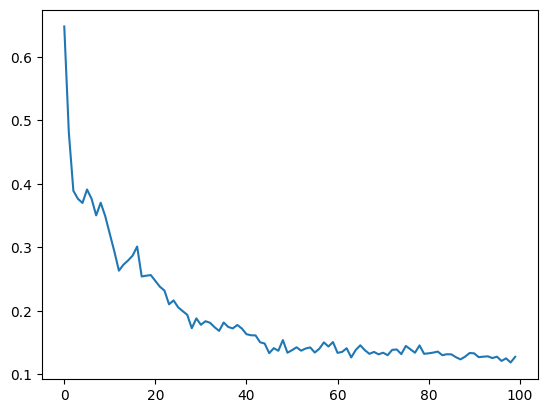

In [158]:
# Plot the data
plt.plot(epoch_loss_list)
# Show the plot
plt.show()

In [159]:
print((epoch_loss_list))

[0.647770816963166, 0.4810615624518444, 0.3889802924202134, 0.3763583882463475, 0.36988905776602526, 0.3910559218128522, 0.3763995154357205, 0.3503050115673492, 0.37021279726177453, 0.3489422468158106, 0.32106360014838475, 0.29336456597782673, 0.2632355886232108, 0.27272714870981873, 0.27920162907180684, 0.28691736972580356, 0.301244939143459, 0.2540964694848905, 0.25534242616035047, 0.2563004716237386, 0.24706494160927833, 0.23795979097795983, 0.23186981786973773, 0.21030908916145563, 0.21641196831129492, 0.20557628884290655, 0.19956536918257672, 0.19373430978817244, 0.17260839200268188, 0.18810908879774313, 0.17801981733180583, 0.1836299987665067, 0.18123771967055896, 0.1742265644700577, 0.1683836720356097, 0.18166291289341946, 0.17457956120992701, 0.17232485122357805, 0.1777498436377694, 0.17210149958419302, 0.16320550211394827, 0.161504781562835, 0.1613244028482586, 0.15051989978179336, 0.1484967964887619, 0.13332158914456765, 0.14123794942162932, 0.13711680908066531, 0.15397441948